In [1]:
import scanpy as sc
import sklearn.model_selection as sks
import numpy as np
import pandas as pd
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import sklearn.metrics as skm
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
import matplotlib.gridspec as gridspec
import matplotlib.colors as clr
from matplotlib.ticker import MaxNLocator

## LOAD Seurat object 

In [2]:
adata = sc.read_h5ad("data/cohort2.h5ad")
adata

AnnData object with n_obs × n_vars = 139848 × 33417
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'percent.mito', 'meanCount_RNA', 'meanCount_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'demultID', 'experiment', 'cartridge', 'ID', 'sample', 'abseq', 'date_of_sampling', 'donor', 'cells', 'purification', 'nCount_AB', 'nFeature_AB', 'group_4', 'group', 'diagnosis', 'onset_of_symptoms', 'outcome', 'oxygen', 'highest_WHO_classification', 'primary_complaint', 'bacterial_superinfection', 'medication', 'comorbidities', 'age', 'sex', 'days_after_onset', 'disease_stage', 'who_per_sample', 'group_per_sample', 'glucocorticoids', 'covid19_therapy', 'leukocyte_counts', 'neutrophil_counts', 'lymphocyte_counts', 'monocyte_counts', 'eosinophil_counts', 'basophil_counts', 'imm_granulocyte_counts', 'thrombocyte_counts', 'pCT', 'CRP', 'IL6', 'group_4_per_sample', 'percent.hb', 'group_per_sample_per_stag

In [3]:
ident=pd.read_csv('data/active_ident_cohort2.csv', index_col = 0)

## Use metadata object to manipulate meta data

In [4]:
metadata = adata.obs
metadata = metadata.set_index(adata.obs.index)
metadata= metadata.replace('NA', np.nan)


## Start prediction ....

Split COVID data (exclude control samples) : 75% training set and 25% test set by preserving classes percentages

In [5]:
df= adata.obsm['X_pca'][adata.obs['Condition']!= 'Control']
meta = adata.obs[adata.obs['Condition']!= 'Control']
df = pd.DataFrame(df, index = meta.index)
y = metadata[metadata['Condition']!= 'Control'].who_per_sample
train, test, y_train, y_test = sks.train_test_split(df,y, test_size=0.25, random_state=42, stratify=y)

Statistics about the split

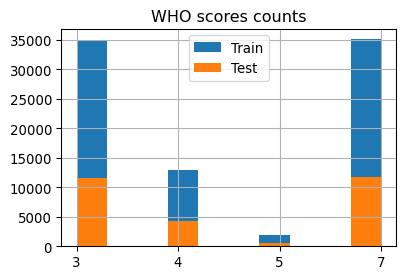

In [6]:
with plt.rc_context({'figure.figsize': (4.5, 3), 'figure.dpi':96}):
    fig, ax = plt.subplots()
    y_train.sort_values().hist( ax=ax)
    y_test.hist( ax=ax)
    ax.legend(['Train','Test'])
    plt.title('WHO scores counts')


In [7]:
metadata['split']= None
metadata.loc[metadata.index.isin(train.index),'split']=0
metadata.loc[metadata.index.isin(test.index),'split']=1

### Apply SVM

In [8]:
# c_values = [0.1, 0.5, 1.0, 1.5,  2.0]
# class_weight = ['balanced', None]
# loss = ['hinge', 'squared_hinge']
# hyperparam_grid = dict(C=c_values,loss= loss, class_weight= class_weight)
# s = svm.LinearSVC(random_state=42)
# clf = sks.GridSearchCV(s,hyperparam_grid,scoring='f1',cv=5, refit=True)
# grid_result = clf.fit(train, y_train)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# pred=clf.predict(test)

In [9]:
# clf = svm.LinearSVC()
# clf.fit(train, y_train)
# pred=clf.predict(test)

In [10]:
n_estimators = [20, 50, 70, 100, 200]
class_weight = ['balanced', None]
hyperparam_grid = dict(n_estimators = n_estimators, class_weight= class_weight)
brf = RandomForestClassifier(random_state=42)
clf = sks.GridSearchCV(brf,hyperparam_grid,scoring='f1',cv=5, n_jobs=-1, refit=True)
grid_result= clf.fit(train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
pred=clf.predict(test)

Best: nan using {'class_weight': 'balanced', 'n_estimators': 20}


In [11]:
metadata['svm']= None
metadata.loc[test.index,'svm']=pred

### Append classification to  metadata

In [12]:
adata.obs['split'] = metadata['split']
adata.obs['svm'] = metadata['svm'].astype(str)

## Plot UMAP with real and predicted classes

Trying to set attribute `.obs` of view, copying.
... storing 'orig.ident' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'HTO_maxID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'HTO_secondID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'HTO_classification' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'HTO_classification.global' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'hash.ID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'demultID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cartridge' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'ID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'abseq' as categorical
Trying to set attrib

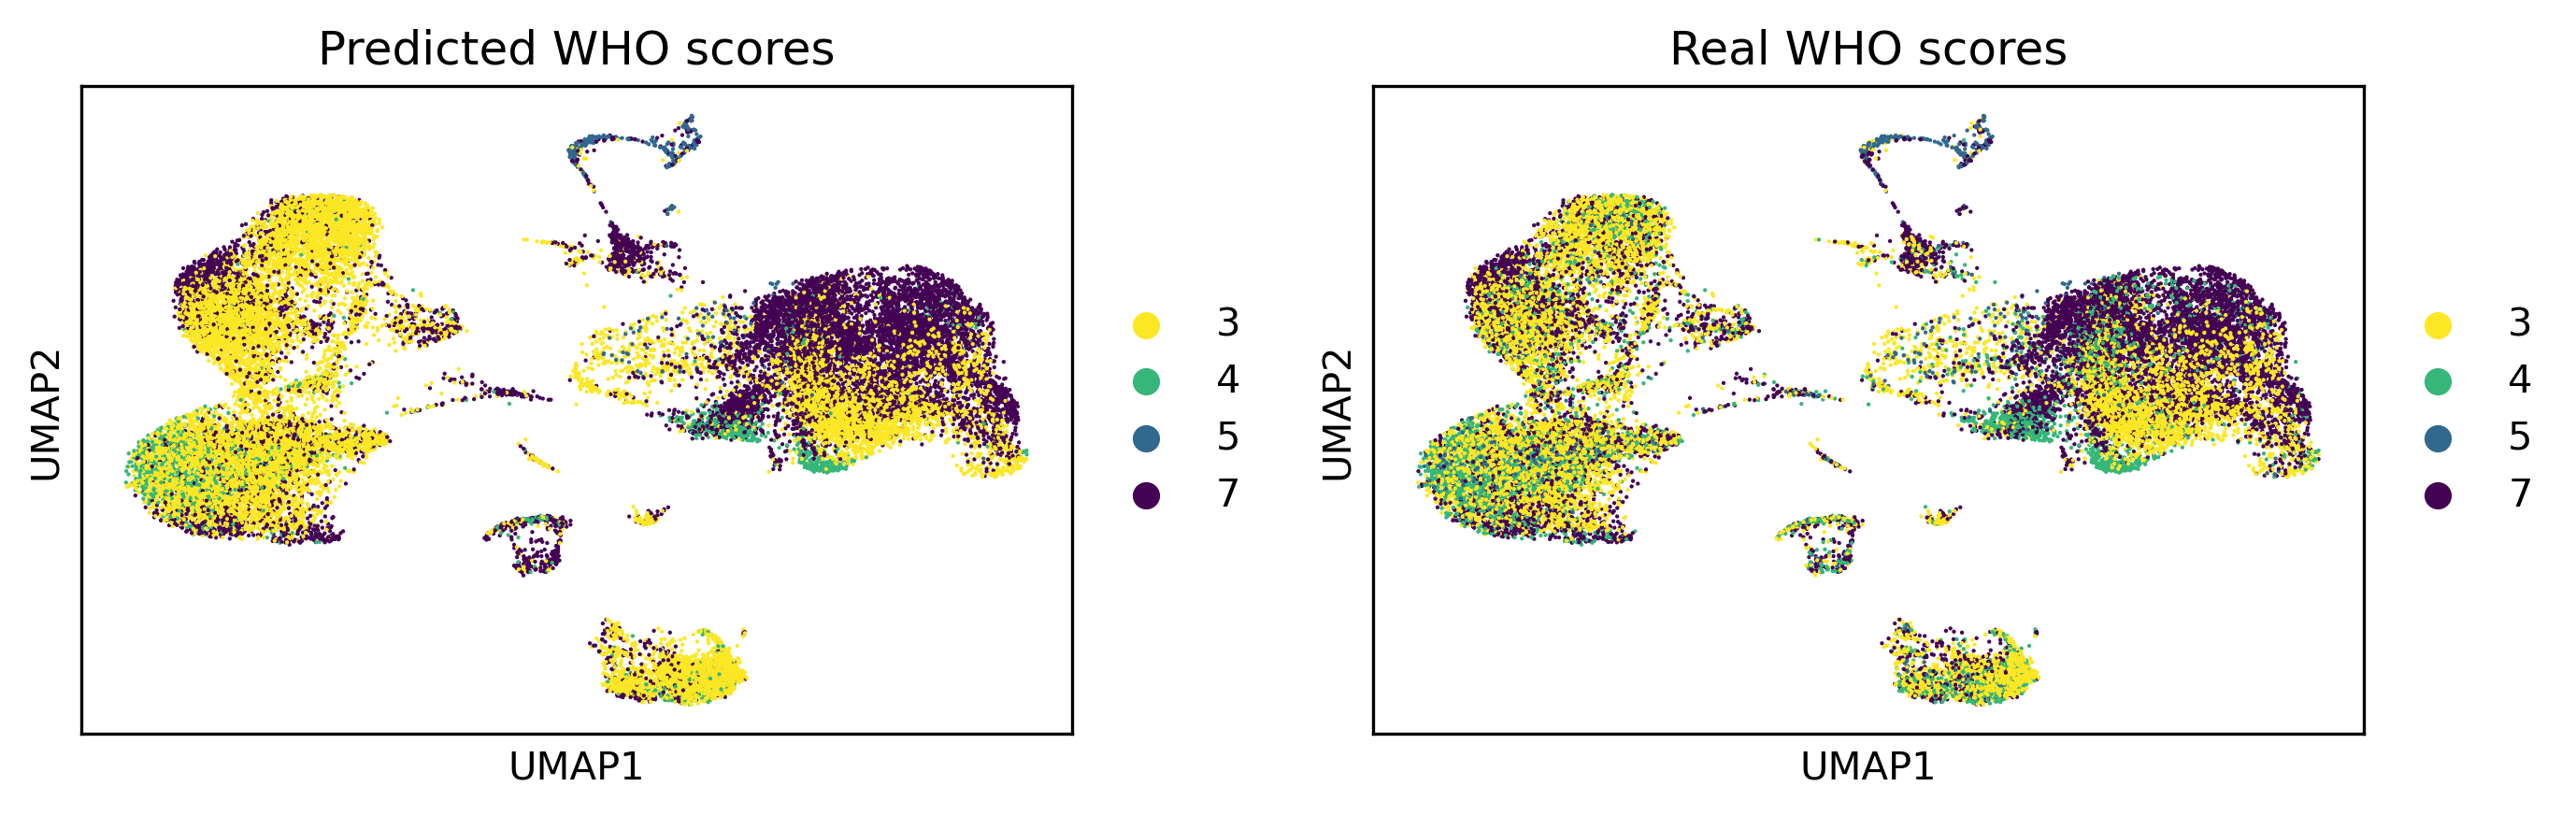

In [13]:
with rc_context({'figure.figsize': (4.5, 3), 'figure.dpi':300}):
    sc.pl.umap(
        adata[adata.obs["split"] == 1],
        color=["svm",'who_per_sample'],
        palette='viridis_r',
        title = ['Predicted WHO scores','Real WHO scores']
    )

## Some evaluation metrics ...

### Classification report

In [14]:
print(skm.classification_report(y_test, pred, target_names=clf.classes_))

              precision    recall  f1-score   support

           3       0.64      0.83      0.72     11632
           4       0.59      0.25      0.35      4293
           5       0.83      0.46      0.59       599
           7       0.76      0.71      0.73     11724

    accuracy                           0.68     28248
   macro avg       0.71      0.56      0.60     28248
weighted avg       0.69      0.68      0.67     28248



### ROC curves

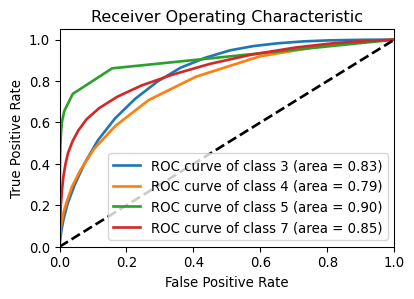

In [16]:
y_score = clf.predict_proba(test)
n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = skm.roc_curve(pd.get_dummies(y_test).loc[:, clf.classes_[i]], y_score[:, i])
    roc_auc[i] = skm.auc(fpr[i], tpr[i])

with rc_context({'figure.figsize': (4.5, 3), 'figure.dpi':96}):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label="ROC curve of class {0} (area = {1:0.2f})".format(clf.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()


### Confusion matrix

In [17]:
# pred_df = pd.DataFrame({"y":y_test,"pred":pred, "value":pred})
# pred_df.pivot_table(index='y', columns='pred',values='value',aggfunc='count')

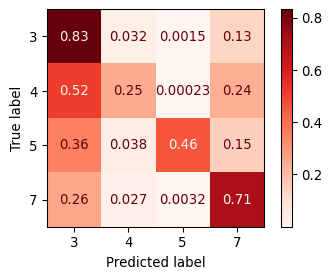

In [18]:
with rc_context({'figure.figsize': (4.5, 3), 'figure.dpi':96}):
    skm.ConfusionMatrixDisplay.from_estimator(
         clf, test, y_test, normalize='true', cmap='Reds')
    plt.show()

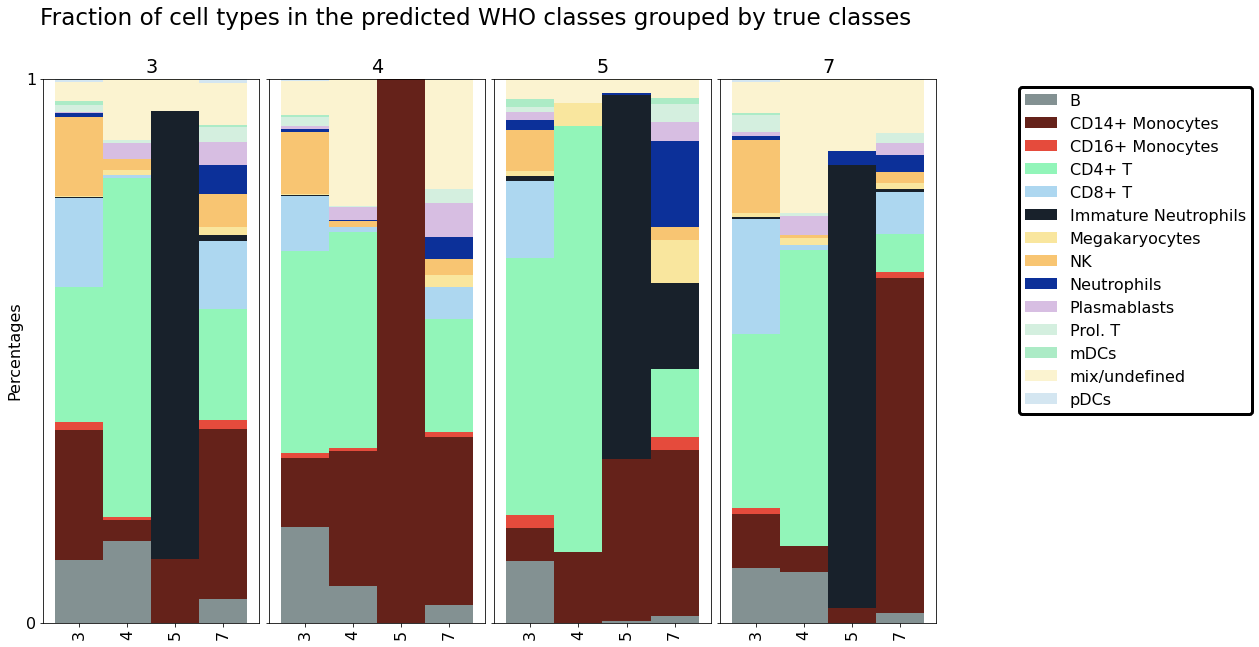

In [20]:

celltype=ident.loc[test.index,'cohort2@active.ident']
dat = pd.DataFrame({"y":y_test,"pred":pred, "celltype":celltype})
dat=pd.DataFrame({'Count' : dat.groupby(['y', 'pred','celltype']).size()}).reset_index()

dat = dat.groupby(["y", "pred", "celltype"])["Count"].sum().unstack(fill_value=0)

dat = dat.div(dat.sum(axis=1), axis=0)
# plotting

clusters = dat.index.levels[0]
inter_graph = 0
maxi = np.max(np.sum(dat, axis=1))
total_width = len(dat)+inter_graph*(len(clusters)-1)

fig = plt.figure(figsize=(total_width,10))
gridspec.GridSpec(1, total_width)
axes=[]
cmap = clr.LinearSegmentedColormap.from_list(
    "", ['#839192','#641e16','#e74c3c','#92f5b9',
         '#aed6f1','#17202a','#f9e79f','#f8c471','#0b2f99','#d7bde2','#d4efdf','#abebc6','#fcf3cf','#d4e6f1'])
ax_position = 0
with rc_context({'figure.figsize': (4.5, 3), 'figure.dpi':96, 'font.size' :16}):

    for cluster in clusters:
        subset = dat.loc[cluster]
        ax = subset.plot(kind="bar", colormap = cmap,stacked=True, width=1, ax=plt.subplot2grid((1,total_width), (0,ax_position), colspan=len(subset.index)))
        axes.append(ax)
        ax.set_title(cluster)
        ax.set_xlabel("")
        ax.set_ylim(0,maxi)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax_position += len(subset.index)+inter_graph

    for i in range(1,len(clusters)):
        axes[i].set_yticklabels("")
        axes[i-1].legend().set_visible(False)
    axes[0].set_ylabel("Percentages")

    fig.suptitle('Fraction of cell types in the predicted WHO classes grouped by true classes', fontsize="x-large")
    legend = axes[-1].legend(loc="upper right", fontsize=16, framealpha=1, bbox_to_anchor=(2.5, 1)).get_frame()
    legend.set_linewidth(3)
    legend.set_edgecolor("black")

    plt.show()